In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# Импортируем необходимые библиотеки для работы с моделью
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модли
from sklearn.model_selection import train_test_split #инструмент для разделения датасета

# Библиотека для работы с регулярными выражениями
import re

# инструменты для скраппинга
import requests
from bs4 import BeautifulSoup

# Библиотека для работы с Natural Language processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Инструмент для кодирования признаков
import category_encoders
# Инструмент для нормализации
from sklearn.preprocessing import MinMaxScaler

# Инструмент для логирования эксперимента
from comet_ml import Experiment

# Libraries to work with geolocation
from geopy.geocoders import Nominatim
from geopy import Bing
from geopy import distance



# Input datafiles are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# создаю эксперимент на Comet, куда буду логировать метрики
experiment = Experiment(
    api_key="HzTbOk8tq4xQsSgFcJqstEQNA",
    project_name="ds-project3",
    workspace="fandox",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Error logging git-related information
COMET INFO: Experiment is live on comet.com https://www.comet.com/fandox/ds-project3/94a0731128034016b0d3876b7edd2227



In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'//hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'//hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'//submission.csv') # самбмишн

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,9.716,488440
1,9.739,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/tmp/ipykernel_288528/2990247136.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


# Описание параметров
- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

In [12]:
df.head(10)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0
5,Coram Street Camden London WC1N 1HT United Kin...,709,8/13/2015,8.2,Holiday Inn London Bloomsbury,Ecuador,They don t have free wifi,7,2995,The location is perfect if you don t have a l...,26,3,"[' Business trip ', ' Solo traveler ', ' Stand...",721 day,51.524125,-0.125807,0,0.0
6,Empire Way Wembley Brent London HA9 8DS United...,1005,8/18/2016,8.3,Holiday Inn London Wembley,United Kingdom,Room generally a bit shabby with some lack of...,35,3469,Location price It did not cost much more to h...,23,11,"[' Leisure trip ', ' Couple ', ' Queen Room ',...",350 day,51.559095,-0.284704,0,0.0
7,1 Shortlands Hammersmith and Fulham London W6 ...,704,8/11/2015,8.3,Novotel London West,Netherlands,Executive rooms 9th Floor don t have a bath T...,52,2443,Comphy bed upgraded to executive room with ne...,42,38,"[' Business trip ', ' Solo traveler ', ' Execu...",723 day,51.491959,-0.220096,0,0.0
8,35 Rue Caumartin 9th arr 75009 Paris France,211,6/25/2016,8.9,Hotel Saint Petersbourg Opera,Ireland,Pity about the two days of rain,8,2412,Its centrality proximity to our destination,7,1,"[' Group ', ' Double or Twin Room ', ' Stayed ...",404 day,48.872174,2.328075,0,0.0
9,49 Gloucester Place Marble Arch Westminster Bo...,61,9/30/2015,7.4,St George Hotel,Canada,Didn t like it at all construction was in pro...,18,334,Didn t like anything about the stay if i had ...,25,1,"[' Couple ', ' Standard Triple Room ', ' Staye...",673 day,51.518277,-0.158351,0,0.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Работа с пропусками

In [14]:
# проверяю наличие пропусков
df.isnull().mean()

hotel_address                                 0.000000
additional_number_of_scoring                  0.000000
review_date                                   0.000000
average_score                                 0.000000
hotel_name                                    0.000000
reviewer_nationality                          0.000000
negative_review                               0.000000
review_total_negative_word_counts             0.000000
total_number_of_reviews                       0.000000
positive_review                               0.000000
review_total_positive_word_counts             0.000000
total_number_of_reviews_reviewer_has_given    0.000000
tags                                          0.000000
days_since_review                             0.000000
lat                                           0.006337
lng                                           0.006337
sample                                        0.000000
reviewer_score                                0.000000
dtype: flo

Text(0.5, 1.0, 'Тепловая карта пропусков')

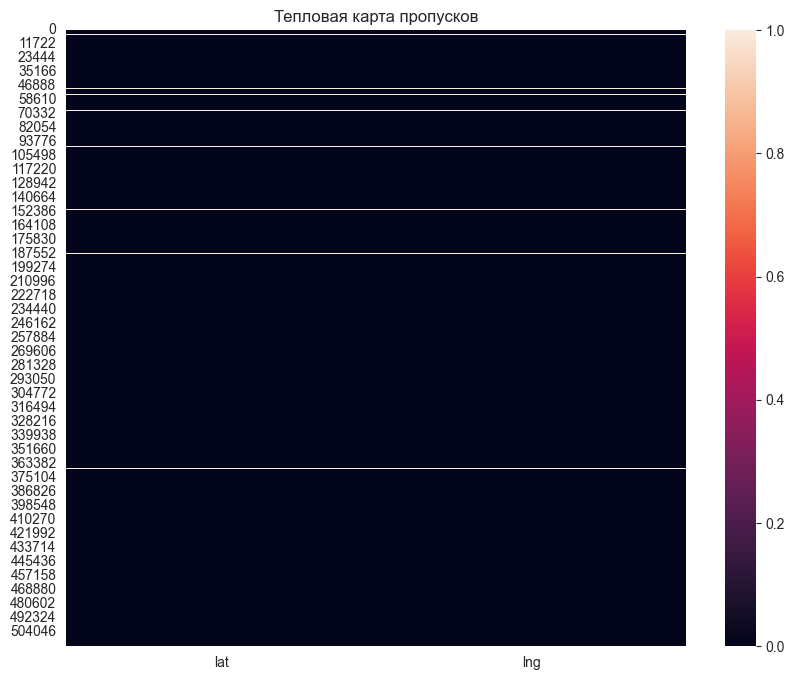

In [15]:
# настраниваю размеры графика
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    df[['lat','lng']].isnull(),
    ax = ax
).set_title('Тепловая карта пропусков')

### Выводы
- Пропуски содержатся в 2 признаках
- Их одинаковое количество
- Визуально они находятся в 1 и тех же записях
- Есть 2 предположения:
  - Пропуски зарегистрированы у отелей с известными координатами (данные для заполнения можно будет взять из других записей)
  - Пропуски зафиксировны у уникальных отелей

Ниже провожу несколько опытов, чтобы в этом убедиться


In [16]:
# формирую списки индексов записей с пропусками широты и долготы
# убеждаюсь, что гипотеза верна, пропуски в 1 и тех же записях

lat_nans = df[df.lat.isnull()].index
lng_nans = df[df.lat.isnull()].index
if (lat_nans == lng_nans).all():
    print('correct')

correct


In [17]:
# Проверяю 2ое предположение
# создаю 2 множества с навзваниями отелей в которых есть пропуски и нет пропусков, и проверяю их пересечение

data_set1 = df[(df.lat.isnull()) | (df.lng.isnull())].hotel_address.unique()
data_set2 = df[(df.lat.notnull()) | (df.lng.notnull())].hotel_address.unique()

hotels_with_loc = set()
hotels_with_loc.update(data_set2)

hotels_without_loc = set()
hotels_without_loc.update(data_set1)

if len(hotels_with_loc.intersection(hotels_without_loc)) == 0:
    print(f'correct, len(hotels_without_loc == {len(hotels_without_loc)}')


correct, len(hotels_without_loc == 17


Сет, пустой, пересечений нет, значит в систетеме есть всего 17 отелей без координат

## Заполнение пропусков

In [18]:
# Для заполнения пользуюсь библиотекой geoPy, идея заполнить координаты по адресу

geolocator = Bing(api_key='AuCIQtaLUz6vtlu2pj0frsl4gVOSm0z5VCJLGX_2RBw3HTTtEIybWzkZ-BPcL2n8') # Создаю объект для работы с адресами

# Создаю словарь с координатами хотелей с некорректными именами
location_dict = {}
for i in hotels_without_loc:
    try:
        location = geolocator.geocode(i)
        location_dict[i] = (location.address,location.latitude,location.longitude)  # корректирую адрес для включения символов utf-8
    except AttributeError: # в случае, если не получилось получить информации по address
        continue

#location_dict

Качество замены адресов неидеальное, bing справился лучше googlemaps 3/17 ошибок

In [19]:
# заменяю пропуски значениями из словаря location_dict

def replacement(data):
    '''
    Функция для заполнения 3 значений записей df: lat, lng
    :param data: запись df
    :return: обновленная запись df с заполненными значениями
    '''
    if data.hotel_address in location_dict: # сравнение значения признака hotel_address со списком адресов с пропусками
        data['lat'] = location_dict[data.hotel_address][1]
        data['lng'] = location_dict[data.hotel_address][2]
    return data

df = df.apply(replacement,axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Выводы
- датасет не содержит пропусков
- по условиям задачи, предполагается, что данные предварительно очищены: очиски выбросов и дубликатов не производится

# Создание новых признаков

## Обработка дат
- days_since_review
- review_date

In [21]:
# Работаю с review_date, вычленяю основную информацию

df['review_date'] = pd.to_datetime(df.review_date)
df['review_year'] = df.review_date.dt.year
df['review_dayofweek'] = df.review_date.dt.dayofweek
df['review_month'] = df.review_date.dt.month

In [22]:
# преобразовываю признак days_since_review, убираю 'days'

df['days_since_review'] = df.days_since_review.apply(lambda x: re.match(r'\d*',x).group(0))
df['days_since_review'] = pd.to_numeric(df.days_since_review)

In [23]:
# удаляю дату, т.к она впоследствии не потребуется
df.drop('review_date',axis=1,inplace=True)

Text(0.5, 1.0, 'Коробчатая диаграмма распределения reviewer_score в разрезе "review_month"')

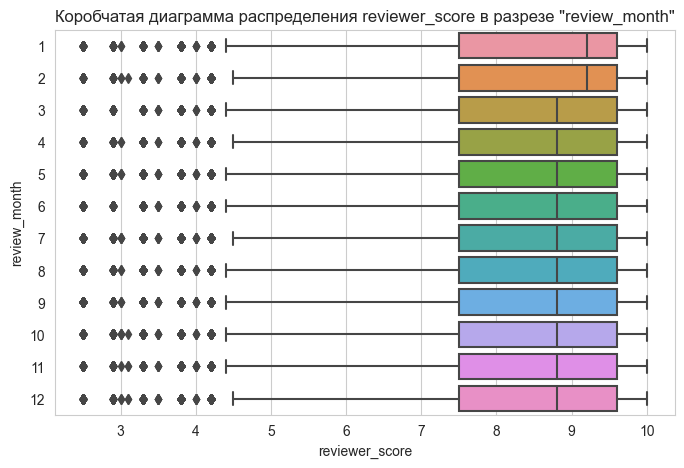

In [24]:
# 3 признака являются биннингом признака days since_review
# Попробую посмотреть какие есть зависимости

plt.subplots(figsize=(8, 5))
sns.boxplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    y = 'review_month',
    orient = 'h',
).set_title('Коробчатая диаграмма распределения reviewer_score в разрезе "review_month"')

Text(0.5, 1.0, 'Коробчатая диаграмма распределения reviewer_score в разрезе "review_month"')

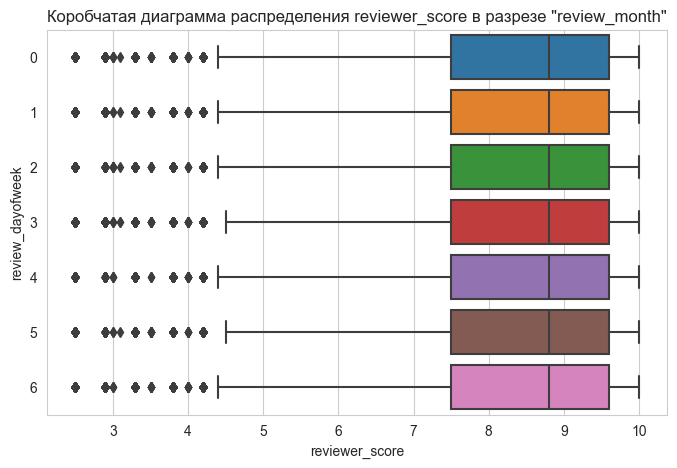

In [25]:
plt.subplots(figsize=(8, 5))
sns.boxplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    y = 'review_dayofweek',
    orient = 'h',
).set_title('Коробчатая диаграмма распределения reviewer_score в разрезе "review_month"')


### Вывод
- Картинка очень похожая
- Я мог ожидать разницу в Декабре и Янаваре, и в Августе (периоды каникул), но нет
- медиана выше в Январе и Феврале
- Январь я могу связать с отпусками, причина Фераля не понятна


Text(0.5, 1.0, 'CDF Признака reviewer_score')

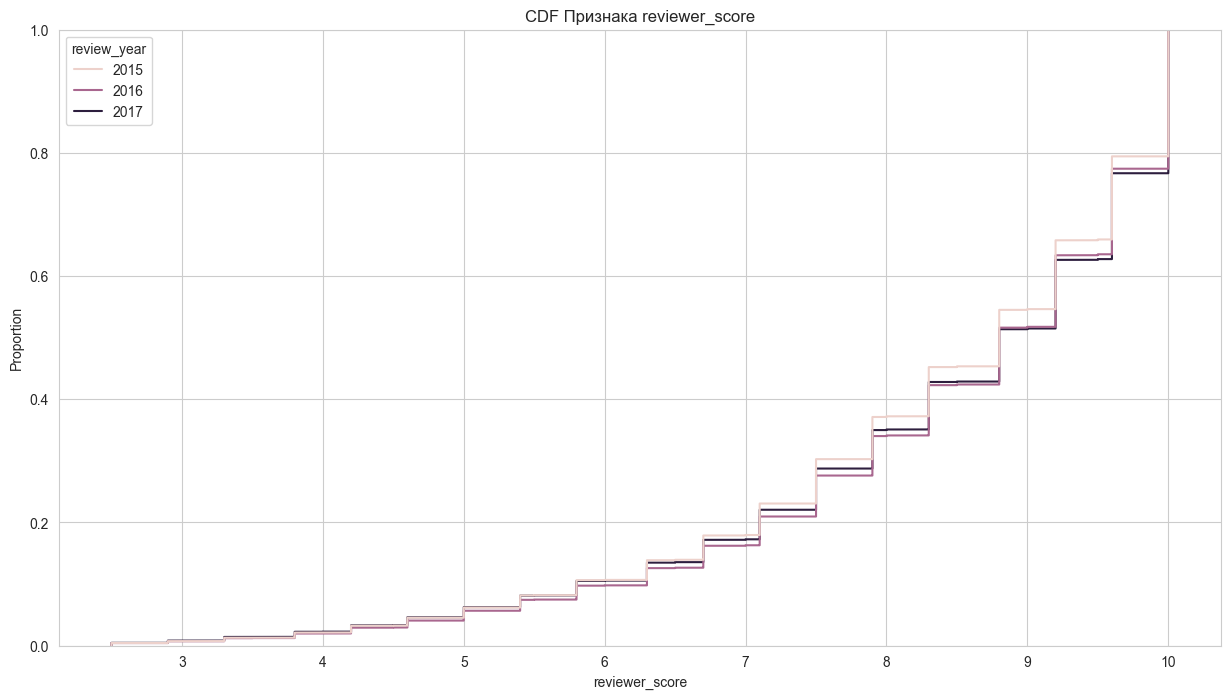

In [26]:
plt.subplots(figsize=(15, 8))
sns.ecdfplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    hue = 'review_year',
).set_title('CDF Признака reviewer_score')

### Вывод
- Оценки в 2015 несколько ниже
- В 2016 вероятность получить оценку до 9 была ниже чем в 2017
- В 2017 было выставлено наибольшее количество высоких оценок

In [27]:
data = df[df['sample']!=0].pivot_table(
    columns = 'review_year',
    index = 'review_month',
    values = 'reviewer_score',
    aggfunc = 'mean'
)

data

review_year,2015,2016,2017
review_month,,,
1,NaN,8.510838,8.457627
2,NaN,8.555485,8.514815
3,NaN,8.520747,8.441461
4,NaN,8.479080,8.385329
5,NaN,8.441245,8.330883
6,NaN,8.404621,8.370436
7,NaN,8.389408,8.283351
8,8.392178,8.431214,8.389083
9,8.255650,8.326231,NaN


Text(0.5, 1.0, 'Тепловая карта среднего балла ревью в разрезе месяца / года')

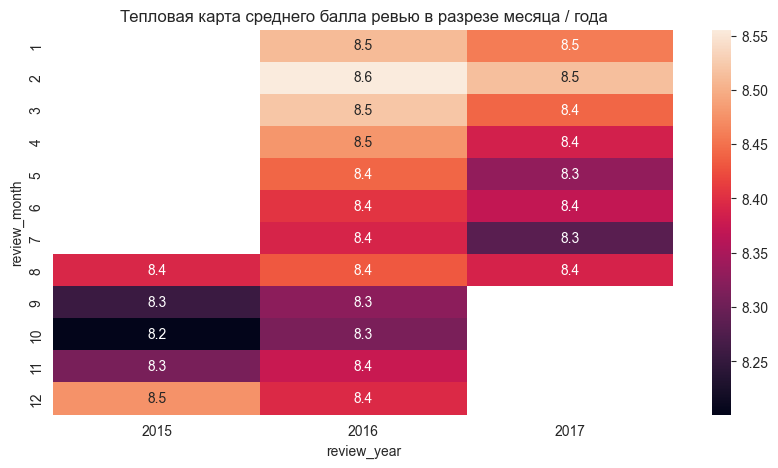

In [28]:
plt.subplots(figsize=(10, 5))
sns.heatmap(
    data,
    annot=True
).set_title('Тепловая карта среднего балла ревью в разрезе месяца / года')

### Вывод
- разница незначительная
- не самый сильный признак

Text(0.5, 1.0, 'Гистограмма признака days_since_review')

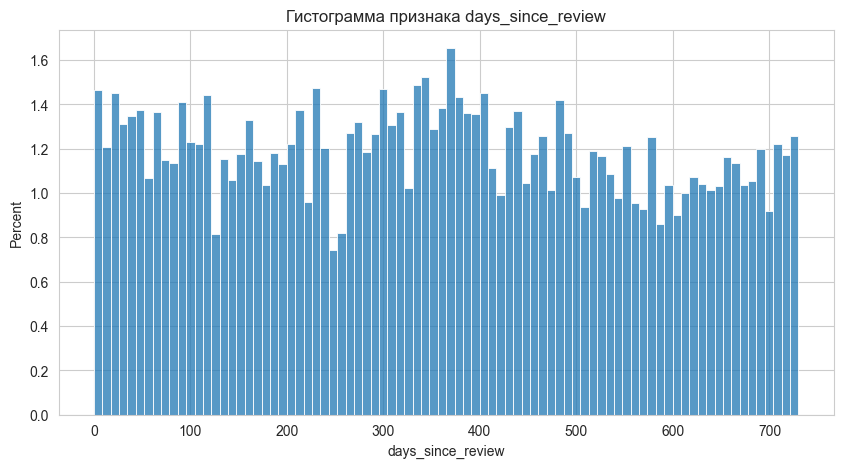

In [29]:
plt.subplots(figsize=(10, 5))
sns.histplot(
    df,
    x = 'days_since_review',
    stat = 'percent'
).set_title('Гистограмма признака days_since_review')

### Вывод
- Распределение близкое к uniform

Text(0.5, 1.0, "Scatter диаграмма зависимости 'days_since_review' и 'reviewer_score'")

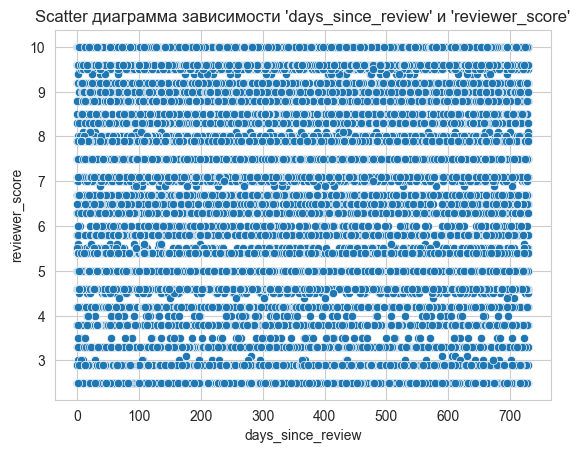

In [30]:
sns.scatterplot(
    df[df['sample']!=0],
    x = 'days_since_review',
    y = 'reviewer_score',
).set_title("Scatter диаграмма зависимости 'days_since_review' и 'reviewer_score'")

### Вывод
- По такой диагрмамме сложно сделать вывод, можно признак представлен во всех катерориях 'примерно' одинаково


## Обработака адреса
- hotel_address

In [31]:
#выделяю город и страну из признака

def get_place(data,type):
    '''
    функция для выделение признаков город и страна из признака hotel_address
    :param data: str, адрес отеля
    :param type: str, определяет возвращаемый признак country или city
    :return: str, название города или страны
    '''
    address = data.split()
    if address[-1] == 'Kingdom': # адрес отелей в UK отличается форматом
        country = ' '.join(address[-2:])
        city = address[-5]
    else:
        country = address[-1]
        city = address[-2]
    if type == 'city':
        return city
    elif type == 'country':
        return country
    return

df['hotel_country'] = df.hotel_address.apply(get_place,args=['country'])
df['hotel_city'] = df.hotel_address.apply(get_place,args=['city'])

In [32]:
# проверяю полученные резултаты
df.groupby(['hotel_city','hotel_country'])['hotel_name'].count()

hotel_city  hotel_country 
Amsterdam   Netherlands        57214
Barcelona   Spain              60149
London      United Kingdom    262301
Milan       Italy              37207
Paris       France             59928
Vienna      Austria            38939
Name: hotel_name, dtype: int64

### Вывод
- Вариативность в сочетании города и страны нет, 2 признака, скорее всего нужны не будут

Text(0.5, 1.0, 'Коробчатая диаграмма распределения reviewer_score в разрезе "reviewer_score"')

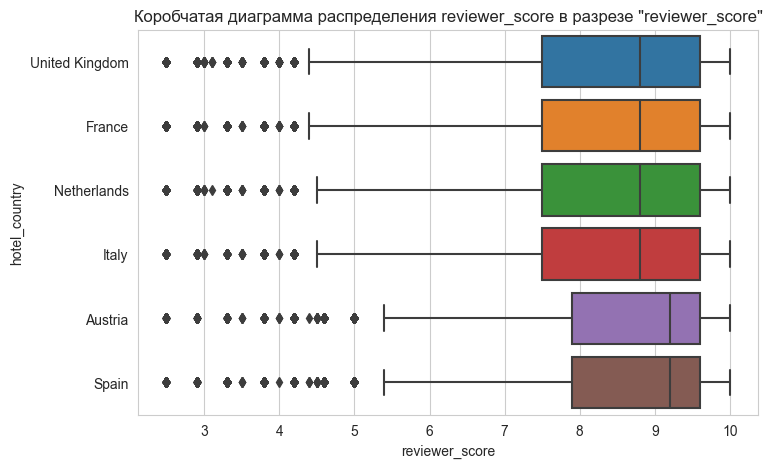

In [33]:
# смотрю есть ли различия в проставленных оценках для разных стран

plt.subplots(figsize=(8, 5))
sns.boxplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    y = 'hotel_country',
    orient = 'h',
).set_title('Коробчатая диаграмма распределения reviewer_score в разрезе "reviewer_score"')

### Вывод
Оценки для отелей в практически одинаковые, средние оценки в Австрии и Испании чуть выше

In [34]:
# смотрю насколько признак получился вариативным
df.hotel_country.value_counts(normalize=True)

United Kingdom    0.508594
Spain             0.116627
France            0.116199
Netherlands       0.110936
Austria           0.075502
Italy             0.072143
Name: hotel_country, dtype: float64

In [35]:
# Выделяю признак расстояние от центра города, это будет категориальный признак, которым я смогу различать разные отели под 1 именем
# Предварительно проверяю количество уникальных сочетаний названия отеля и адреса

list_hotels = df.hotel_name.unique()
address_count = []

for i in list_hotels:
    address_count.append(df[df.hotel_name == i].hotel_address.nunique())

Text(0, 0.5, 'count of unique addresses')

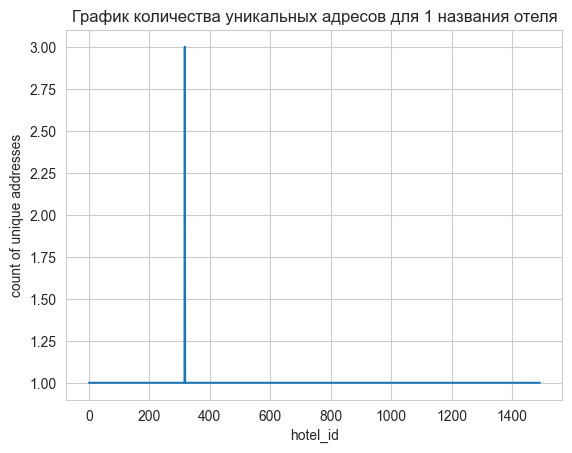

In [36]:
# Строю график для наглядности
plt.plot(range(len(list_hotels)),address_count)
plt.title('График количества уникальных адресов для 1 названия отеля')
plt.xlabel('hotel_id')
plt.ylabel('count of unique addresses')

### Вывод
В наборе данных не представлены
сети отелей или они имеют уникальные названия
Признаки, выделенные и характеризующие отель теоретически будут слабыми, если они не будут связаны с профилем пользователя или данными в комментарии

In [37]:
list_cities = df.hotel_city.value_counts().index
city_centre = {}
for i in list_cities:
    location = geolocator.geocode(i)
    city_centre[i] = (location.latitude,location.longitude)

city_centre

{'London': (51.50015259, -0.12623601),
 'Barcelona': (41.38299942, 2.18300009),
 'Paris': (48.85689545, 2.35084891),
 'Amsterdam': (52.37316513, 4.89065981),
 'Vienna': (48.2084465, 16.37789345),
 'Milan': (45.46361923, 9.18811607)}

In [38]:
# Создаю словарь со списком отелей и считаю для каждого отеля дистанцию в км от центра

list_hotels = df.hotel_address.unique()
hotel_distance = dict()

for i in list_hotels:
    lat = df[df.hotel_address == i].iloc[0]['lat']
    lng = df[df.hotel_address == i].iloc[0]['lng']
    position = city_centre[df[df.hotel_address == i].iloc[0]['hotel_city']]

    result = distance.distance((lat,lng),position)
    hotel_distance[i] = result.km

#hotel_distance

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [40]:
# Заполнчяю новый признак
df['hotel_distance'] = df.hotel_address.apply(lambda x: hotel_distance[x])

In [41]:
# выделяю признак внутреннего туризма, но перед этим очищаю и смотрю на признак страны
df.reviewer_nationality.value_counts(normalize=True)

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
                                ...   
 Comoros                      0.000002
 Anguilla                     0.000002
 Tuvalu                       0.000002
 Cape Verde                   0.000002
 Palau                        0.000002
Name: reviewer_nationality, Length: 227, dtype: float64

In [42]:
# Замечаю, что записи содержат пустое значение и пробелы
# тримлю и заполняю пустое значение

value = df.reviewer_nationality.mode()

def nationality_update(data):
    '''
    Функция для удлаения лиших пробелов в названии страны
    :param data: str, насвание страны происхождения
    :return: str, очищенная строка
    '''
    result = data.strip()
    if result == '':
        return value[0].strip() # если занчение пустое, возвращаю моду, предварительно очистив.
    return result

df['reviewer_nationality'] = df.reviewer_nationality.apply(nationality_update)

In [43]:
# Выделяю признак внутреннего туризма
df['inland_tourism'] = df.apply(lambda x: 1 if x.hotel_country == x.reviewer_nationality else 0, axis=1)

In [44]:
#выдели признаки которые выделяются на фоне других
df['is_from_UK'] = df.reviewer_nationality.apply(lambda x: 1 if x == 'United Kingdom' else 0)
df['is_from_US'] = df.reviewer_nationality.apply(lambda x: 1 if x == 'United States of America' else 0)

Text(0.5, 1.0, 'Коробчатая диаграмма распределения reviewer_score в разрезе "inland_tourism"')

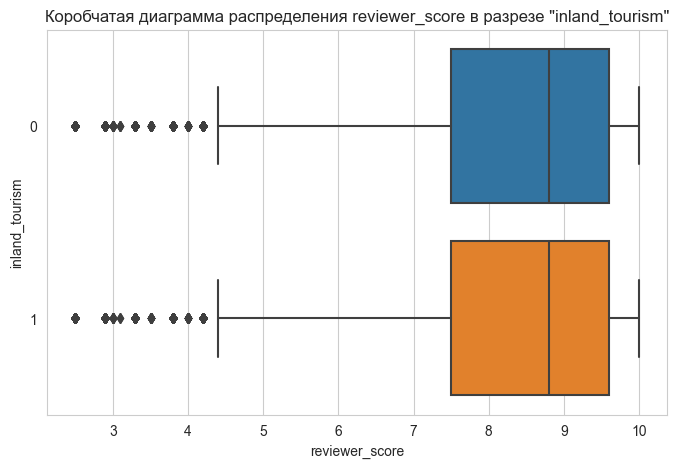

In [45]:
# Смортю на распределение оценок в разрезе признака внутренного туризма

plt.subplots(figsize=(8, 5))
sns.boxplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    y = 'inland_tourism',
    orient = 'h',
).set_title('Коробчатая диаграмма распределения reviewer_score в разрезе "inland_tourism"')

Text(0.5, 1.0, 'Коробчатая диаграмма распределения reviewer_score у пользователей из UK в разрезе "inland_tourism"')

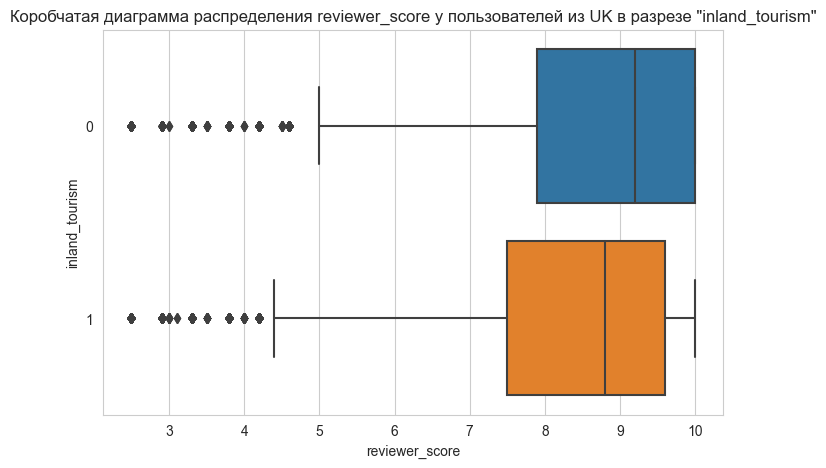

In [46]:
# делаю аналгично для основной группы UK

plt.subplots(figsize=(8, 5))
sns.boxplot(
    df[(df['sample'] != 0) & (df['is_from_UK'] == 1)],
    x = 'reviewer_score',
    y = 'inland_tourism',
    orient = 'h',
).set_title('Коробчатая диаграмма распределения reviewer_score у пользователей из UK в разрезе "inland_tourism"')

Text(0.5, 1.0, 'Коробчатая диаграмма распределения reviewer_score в разрезе "is_from_UK"')

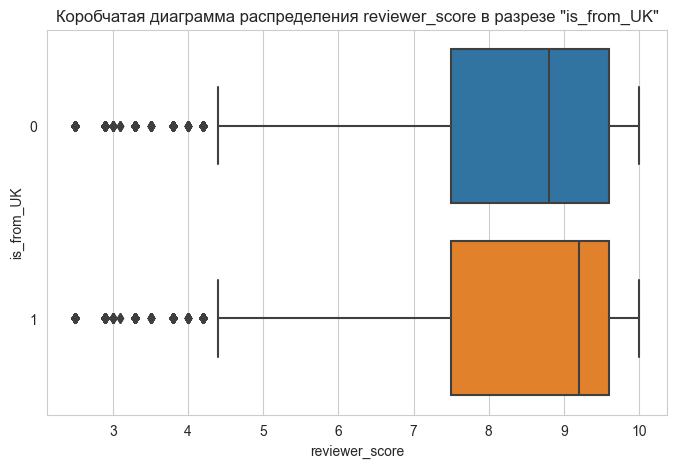

In [47]:
# Сравниваю основную группу туристов со всей выборкой

plt.subplots(figsize=(8, 5))
sns.boxplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    y = 'is_from_UK',
    orient = 'h',
).set_title('Коробчатая диаграмма распределения reviewer_score в разрезе "is_from_UK"')

Text(0.5, 1.0, 'Коробчатая диаграмма распределения reviewer_score в разрезе "is_from_US"')

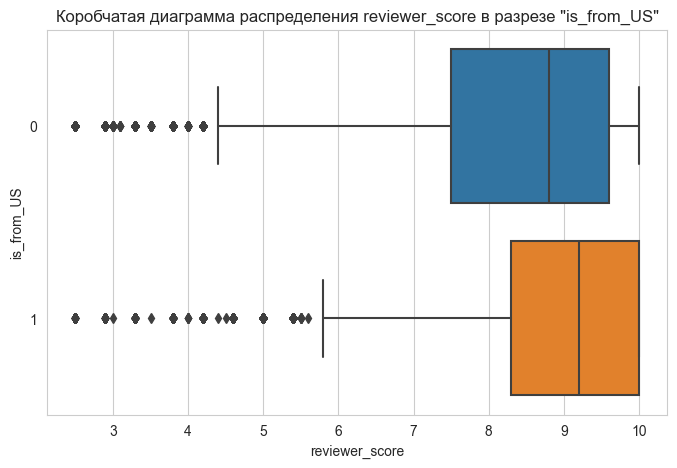

In [48]:
# Делаю тоже самое для туристов из US

plt.subplots(figsize=(8, 5))
sns.boxplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    y = 'is_from_US',
    orient = 'h',
).set_title('Коробчатая диаграмма распределения reviewer_score в разрезе "is_from_US"')


### Выводы
- Признак не самый выразительный
- Оценки британцев дома несколько ниже
- Американцы и британцы ставят в среднем баллы выше, чем туристы из других стран

In [49]:
# произвожу дополнительный бинниг, распределяя странцу происхождения по регионам
# Буду рассматривать 6 регионов
europe = set()
asia = set()
namerica = set()
lamerica = set()
africa = set()
oceania = set()

url_asia = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_Asia'
response = requests.get(url_asia) # Выполняем get запрос
page = BeautifulSoup(response.text, 'html.parser') # считываю сраницу
tables = page.find_all('table', class_ = 'wikitable') # выбираем все таблицы на странице

for i in tables:
    for j in i.find_all('tr')[1:]: # прохожусь по строкам таблицы
        asia.add(j.find_all('a')[2].text) # выбираю интересубщие меня ссылки

url_europe = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_Europe'
response = requests.get(url_europe)
page = BeautifulSoup(response.text, 'html.parser')
tables = page.find_all('table', class_ = 'wikitable')[1:] #страны начинаютс со 2 таблицы

for i in tables:
    for j in i.find_all('tr')[1:]:
        europe.add(j.find_all('a')[2].text)

europe.remove('[e]') # ссылка на строке с Чехией отличается, поэтому приходиться делать преобразования вручную
europe.add('Czech Republic')

# Смотрю на пересечение множеств и удаляю пересечение
intersections = europe.intersection(asia)
for i in intersections:
    europe.remove(i)

for i in europe.intersection(asia):
    europe.remove(i)

url_america = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_the_Americas'
response = requests.get(url_america) # Выполняем get запрос
page = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер
tables = page.find_all('table', class_ = 'wikitable') # выбираем все таблицы на странице

for i in tables:
    for j in i.find_all('tr')[1:]:
        lamerica.add(j.find_all('a')[1].text)

lamerica.remove('Canada')
lamerica.remove('United States')

namerica.update(['Canada','United States of America']) # создаю отдельно регион Северное Америки, т.к предполагаю здесь другое поведение

url_africa = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_Africa'
response = requests.get(url_africa) # Выполняем get запрос
page = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер
tables = page.find_all('table', class_ = 'wikitable') # выбираем все таблицы на странице

for i in tables:
    for j in i.find_all('tr')[1:]:
        africa.add(j.find_all('a')[2].text)


url_oceania = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_Oceania'
response = requests.get(url_oceania) # Выполняем get запрос
page = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер
tables = page.find_all('table', class_ = 'wikitable') # выбираем все таблицы на странице

for i in tables:
    for j in i.find_all('tr')[1:]:
        oceania.add(j.find_all('a')[2].text)

oceania.remove('')

In [50]:
# произовжу биннинг по регионам

def def_region(data):
    '''
    Функция возвращает по названию страны: название региона
    :param data: str название страниы
    :return: str название региона
    '''
    if data in europe:
        return 'europe'
    elif data in asia:
        return 'asia'
    elif data in namerica:
        return 'namerica'
    elif data in lamerica:
        return 'lamerica'
    elif data in africa:
        return 'africa'
    elif data in oceania:
        return 'oceania'
    else:
        return 'other'

df['reviewer_region'] = df.reviewer_nationality.apply(def_region)


In [51]:
df[df['sample']!=0].groupby('reviewer_region')['reviewer_score'].agg(['describe'])

describe                                               
                    count      mean       std  min  25%  50%   75%   max
reviewer_region                                                         
africa             4986.0  8.254773  1.636557  2.5  7.5  8.8   9.6  10.0
asia              59548.0  8.096588  1.766887  2.5  7.1  8.3   9.6  10.0
europe           266684.0  8.408939  1.620292  2.5  7.5  8.8   9.6  10.0
lamerica           3790.0  8.485646  1.580321  2.5  7.5  8.8   9.6  10.0
namerica          32525.0  8.746367  1.508320  2.5  7.9  9.2  10.0  10.0
oceania           18718.0  8.596827  1.473749  2.5  7.9  9.2   9.6  10.0
other               552.0  8.285326  1.718666  2.5  7.5  8.8   9.6  10.0

### Выводы
Туристы из азии ставят в среднем менее высокие оценки
Туристы и US и Canada ставят в среднем самые высокие оценки

## Выделение признаков из тегов
- tags

In [52]:
df.tags

0         [' Leisure trip ', ' Couple ', ' Double Room '...
1         [' Leisure trip ', ' Group ', ' Triple Room ',...
2         [' Business trip ', ' Solo traveler ', ' Twin ...
3         [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4         [' Business trip ', ' Solo traveler ', ' Class...
                                ...                        
515733    [' Leisure trip ', ' Group ', ' Club Double or...
515734    [' Leisure trip ', ' Couple ', ' Standard Doub...
515735    [' Business trip ', ' Solo traveler ', ' Singl...
515736    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
515737    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 515738, dtype: object

In [53]:
# выделяю уникальные теги

def tags_list():
    tags = set() # создаю пустое множество, которое будет заполняться во внутренней функции
    def innter_func(data):
        nonlocal tags
        data = data [1:-2] # убираю скобки
        list_tags = data.split(',')
        for i in list_tags:
            tags.add(i.strip()[2:-2]) # удаляю структуру " ' ' "
        return tags
    return innter_func

my_func = tags_list()
for i in df.tags:
    tags = my_func(i)

print(tags)

{'Double Room with Club Lounge Access', 'Superior Room with Club Lounge Access Free Wifi', 'Classic Designer', 'Grand Junior Suite', 'King Suite Non Smoking', 'Deluxe Double Room Pigalle 21', 'Terrace Junior Suite', 'Superior Double Room with View', 'Studio Twin Room', 'Luxury King Room with River View', 'Luxury Suite Patio', 'Deluxe Room with 1 King bed', 'Executive Double or Twin Room La Ravissante', 'Cool Corner Room', 'Special Offer Twin Room', 'Double Room 3 Adults', 'Stayed 6 nigh', 'Two Connecting Rooms with Free Access to Hamman', 'Weekend Offer Standard Studio', 'Deluxe Twin Room', 'Executive Double Room with Sofa Bed', 'Twin Room with City View Top Floor', 'Superior Room with Garden View', 'Superior Room with Queen size bed and Sofa Bed', 'Grande Suite', 'Corner Twin Room', 'Deluxe Boulevard Double Room', 'King Accessible Superior Room', 'Park King or Twin', 'Suite 2 Adults 1 Child', 'Atrium', 'Junior Suite with Cathedral View', 'Master Suite with Club Lounge Access', 'Three 

In [54]:
# первым выделяю тип поездки Business или leisure
def trip_type(data):
    '''
    Функция выделения типа поездки из tag
    :param data: str, список tag’ов
    :return: str тип поездки Business/Leisure/other
    '''
    try:
        result = re.findall(r'(\w*) trip', data)[0]
    except IndexError: # если ничего не нашли и result содержит []
        return np.nan
    if result == 'Business':
        return 'Business'
    elif result == 'Leisure':
        return 'Leisure'
    else: #на случай, если есть другие типы поездки
        return 'Other'

df['trip_type'] = df.tags.apply(trip_type)

In [55]:
# Проверяю что получилось
df.trip_type.value_counts(dropna=False)

Leisure     417778
Business     82939
NaN          15021
Name: trip_type, dtype: int64

In [56]:
# Заполняю пропуски
df['trip_type'] = df.trip_type.fillna('Other')

Text(0.5, 1.0, 'CDF признака reviewer score в разрезе trip_type')

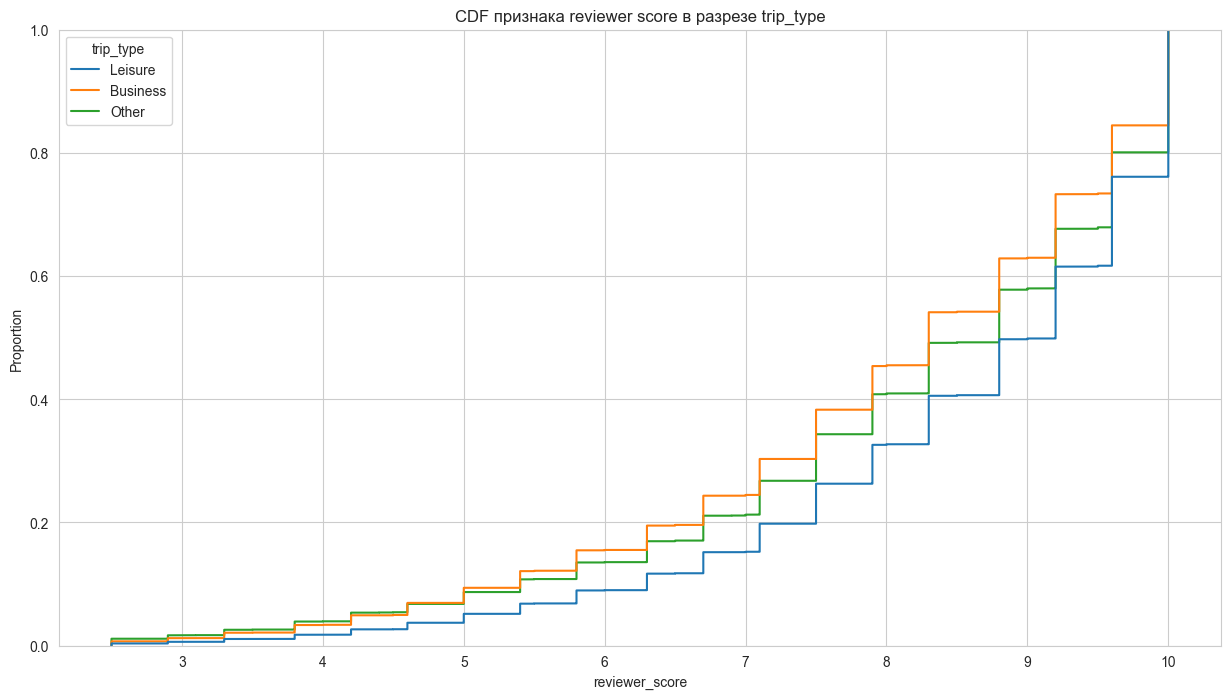

In [57]:
# Смотрю как отличаются значения выдаваемых оценок от признака типа поездки

plt.subplots(figsize=(15, 8))
sns.ecdfplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    hue = 'trip_type',
).set_title('CDF признака reviewer score в разрезе trip_type')



### Выводы
- Вusiness поездки оценивются ниже чем туристические,
- медиана бизнесс поездок в районе 8.3, тогда как для туристических в районе 9
- Возможно, будет иметь смысл применить порядковое кодирование для этого признака

In [58]:
# Выделяю количество ночей
def n_nights(data):
    '''
    Функция для выделения количество ночей
    :param data: str, строка tags
    :return: int количество ночей или пустое значение
    '''
    try:
        result = re.findall(r'Stayed (\d*) night', data)[-1]
        return int(result)
    except IndexError: # если ничего не нашли и result содержит []
        return np.nan

df['nights_count'] = df.tags.apply(n_nights)

In [59]:
# проверяю пропуски
df.nights_count.isnull().mean()

0.0003722820501882739

Text(0.5, 1.0, 'Гистограмма признака nights_count')

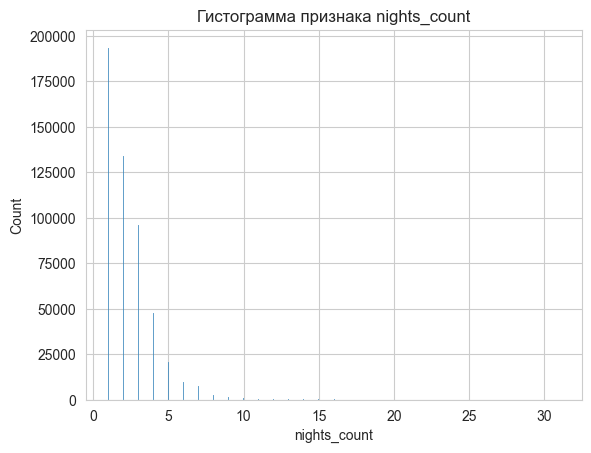

In [60]:
sns.histplot(
    df,
    x = df.nights_count
).set_title('Гистограмма признака nights_count')

Text(0.5, 1.0, 'Гистограмма признака nights_count после заполнения пробелов')

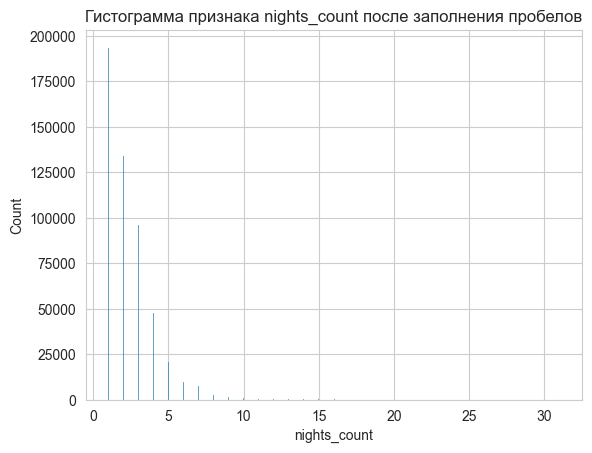

In [61]:
# Заполняю средним значением и проверяю распределение
df['nights_count'] = df.nights_count.fillna(int(df.nights_count.mean()))

sns.histplot(
    df,
    x = df.nights_count
).set_title('Гистограмма признака nights_count после заполнения пробелов')

Text(0.5, 1.0, "Scatter диаграмма зависимости 'days_since_review' и 'reviewer_score'")

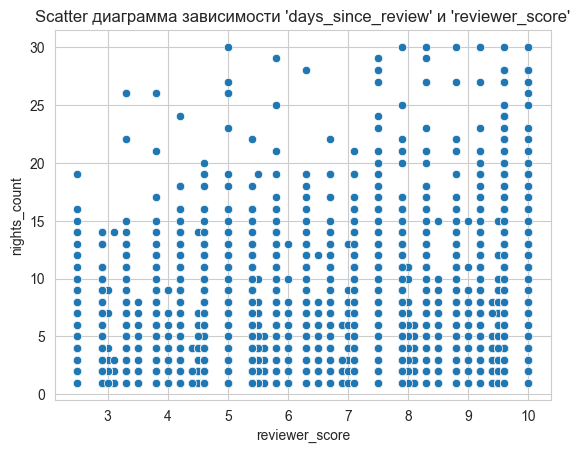

In [62]:

sns.scatterplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    y = 'nights_count',
).set_title("Scatter диаграмма зависимости 'days_since_review' и 'reviewer_score'")

### Выводы
- Какой-то четкой корреляции я не вижу
- Можно сказать, что начиная от 20 ночей посетители, в основном, ставят высоеи баллы (больше 7.5)

In [63]:
#Определяю, тип группы туриста

# создаю словарь, который буду использовать для кодирования впоследсвии
group_types = {
    'Couple': 3,
    'Group': 2,
    'Solo traveler': 1,
    'Family with older children': 2,
    'Family with young children': 2,
    'Travelers with friends': 4
}

find_string = '|'.join(group_types.keys()) # создаю регулярное выражение

def group_type(data):
    '''
    Функция для определения типа группы
    :param data: str, строка df.tags
    :return: str, тип группы
    '''
    try:
        result = re.findall(find_string, data)[0]
        return result
    except IndexError: # если ничего не нашли и result содержит []
        return np.nan

df['group_type'] = df.tags.apply(group_type)

In [64]:
# проверяю пропуски
df.group_type.isnull().mean()

0.0

Text(0.5, 1.0, 'Box диаграмма reviewer score в разрезе group_type')

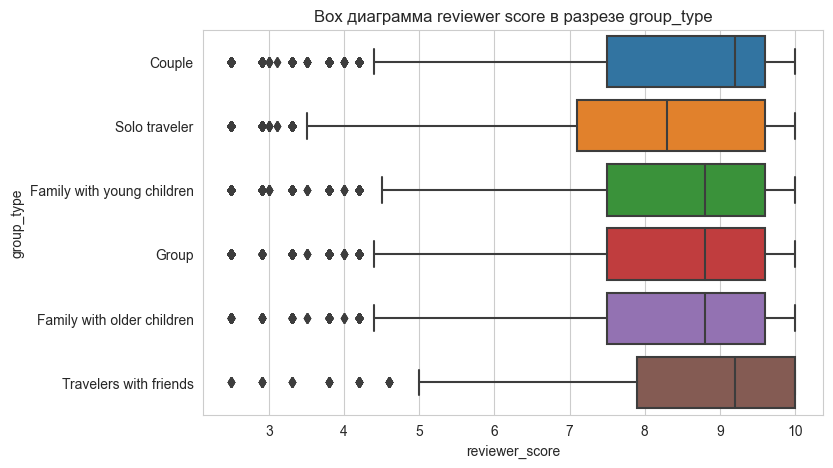

In [65]:
# Смотрю, есть ли какие-то тренды оценки в зависимости от группы

plt.subplots(figsize=(8, 5))
sns.boxplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    y = 'group_type',
    orient = 'h',
).set_title('Box диаграмма reviewer score в разрезе group_type')

### Выводы
- Результаты выглядят неожиданными
- Самые довольные - путещественники c друзьями
- Самые недовольные - путешественники соло
- Путешественники группой и фамилией имеют очень похожее распределение, верояно, это разные теги для 1 и того же

In [66]:
# Попытка определить качество снимаемой комнаты

# Создаю словарь с прилагательными, которые теоритически должны свидетельствовать о повышенном комфорте (цене) номера
adjectives = [
    'Royal',
    'Queen',
    'King',
    'Superior',
    'Deluxe',
    'Executive',
    'Premium',
    'Prestige',
    'Supreme',
    'Privilege',
    'Luxury',
    'Grand'
]

find_string = '|'.join(adjectives) # создаю regexp

def room_qlt(data):
    '''
    Функция находит включения в строку прилагательных описывающих комнаты повышенного качества
    :param data: str, df.tags
    :return: 1 в случае совпадение, 0 в противном случае
    '''
    try:
        re.findall(find_string, data)[0] #смотрим, есть ли результаты в сприске
        return 1
    except IndexError: # если ничего не нашли и result содержит []
        return 0

df['room_quality'] = df.tags.apply(room_qlt)

In [67]:
# смотрю на результаты
df.room_quality.value_counts(normalize=True)

0    0.586831
1    0.413169
Name: room_quality, dtype: float64

Text(0.5, 1.0, 'CDF признака reviewer score в разрезе room_quality')

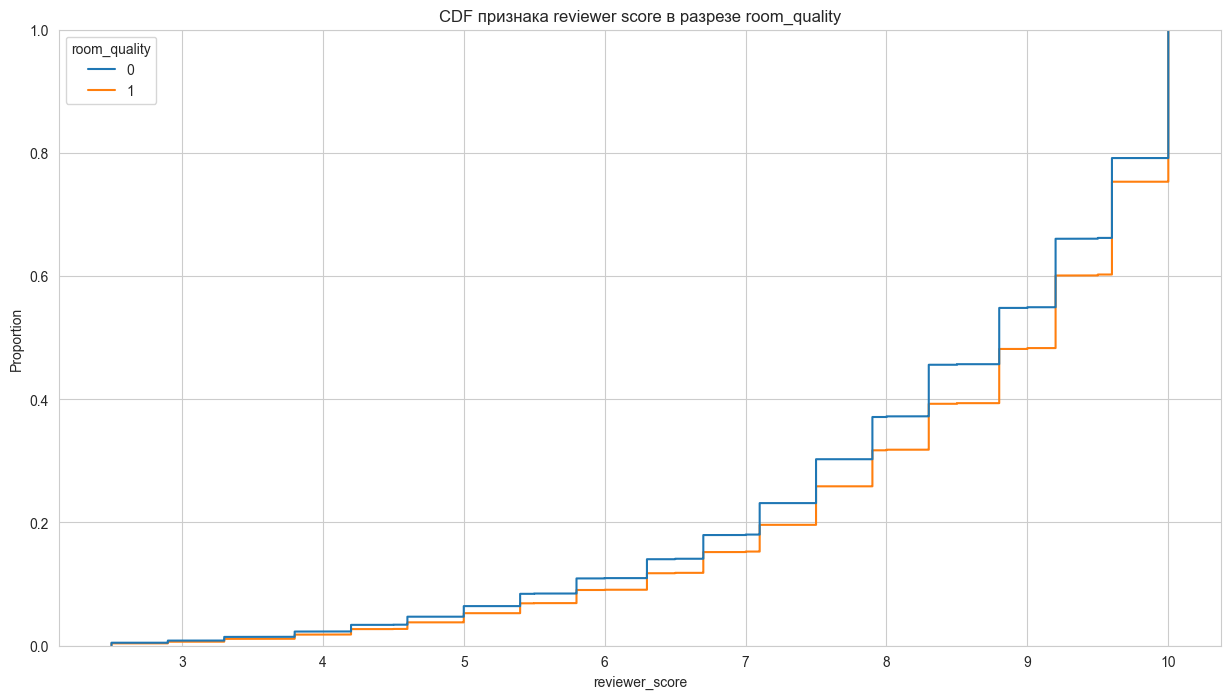

In [68]:
# Смотрю о том можно ли сказать что есть разница в оценке

plt.subplots(figsize=(15, 8))
sns.ecdfplot(
    df[df['sample']!=0],
    x = 'reviewer_score',
    hue = 'room_quality',
).set_title('CDF признака reviewer score в разрезе room_quality')

### Выводы
Догорие номера отражаются в более высоких оценках


In [69]:
df.head(20)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,hotel_city,hotel_distance,inland_tourism,is_from_UK,is_from_US,reviewer_region,trip_type,nights_count,group_type,room_quality
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,Milan,7.839941,0,1,0,europe,Leisure,2.0,Couple,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,Amsterdam,4.072399,0,0,0,europe,Leisure,1.0,Group,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,Barcelona,2.123467,0,0,0,europe,Business,1.0,Solo traveler,0
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,Milan,1.917992,0,0,1,namerica,Leisure,1.0,Couple,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,Amsterdam,0.322295,0,1,0,europe,Business,2.0,Solo traveler,0
5,Coram Street Camden London WC1N 1HT United Kin...,709,8.2,Holiday Inn London Bloomsbury,Ecuador,They don t have free wifi,7,2995,The location is perfect if you don t have a l...,26,...,London,2.667268,0,0,0,lamerica,Business,1.0,Solo traveler,0
6,Empire Way Wembley Brent London HA9 8DS United...,1005,8.3,Holiday Inn London Wembley,United Kingdom,Room generally a bit shabby with some lack of...,35,3469,Location price It did not cost much more to h...,23,...,London,12.803869,1,1,0,europe,Leisure,1.0,Couple,1
7,1 Shortlands Hammersmith and Fulham London W6 ...,704,8.3,Novotel London West,Netherlands,Executive rooms 9th Floor don t have a bath T...,52,2443,Comphy bed upgraded to executive room with ne...,42,...,London,6.581660,0,0,0,europe,Business,3.0,Solo traveler,1
8,35 Rue Caumartin 9th arr 75009 Paris France,211,8.9,Hotel Saint Petersbourg Opera,Ireland,Pity about the two days of rain,8,2412,Its centrality proximity to our destination,7,...,Paris,2.383037,0,0,0,europe,Other,1.0,Group,0
9,49 Gloucester Place Marble Arch Westminster Bo...,61,7.4,St George Hotel,Canada,Didn t like it at all construction was in pro...,18,334,Didn t like anything about the stay if i had ...,25,...,London,3.006229,0,0,0,namerica,Other,2.0,Couple,0


Text(0.5, 1.0, 'Тепловая карта зависимости длины отзыва на среднюю оценку')

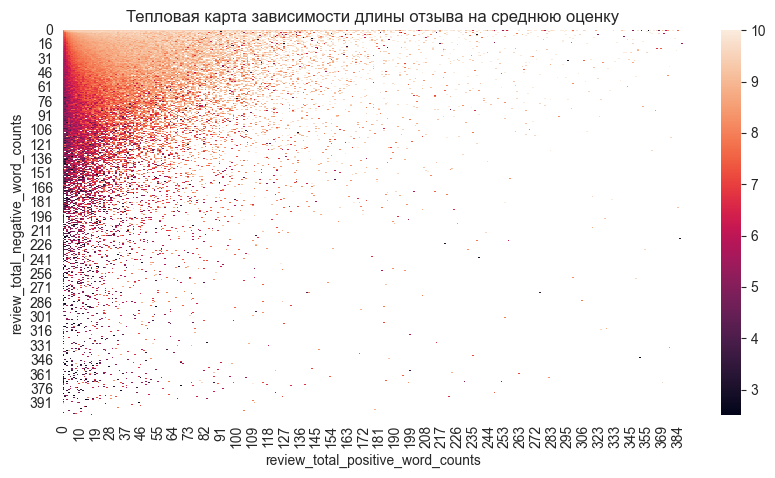

In [70]:
# смотрю как оценка связана с длиной комментариев осталенных пользователем
data = df[df['sample']!=0].pivot_table(
    index = 'review_total_negative_word_counts',
    columns = 'review_total_positive_word_counts',
    values = 'reviewer_score',
    aggfunc = 'mean'
)

plt.subplots(figsize=(10, 5))
sns.heatmap(
    data
).set_title('Тепловая карта зависимости длины отзыва на среднюю оценку')

### Выводы
- Большинство оценок находится в интервале от до 100 символов
- Отсутствиуют длинные негативные и позитивные отзывы одновременно
- Отзыв больше 100 символов говорит о том, что оцека будет или высокой или низкой (в зависимости от типа комментария)

Text(0.5, 1.0, 'Box диаграмма reviewer score в разрезе average_score')

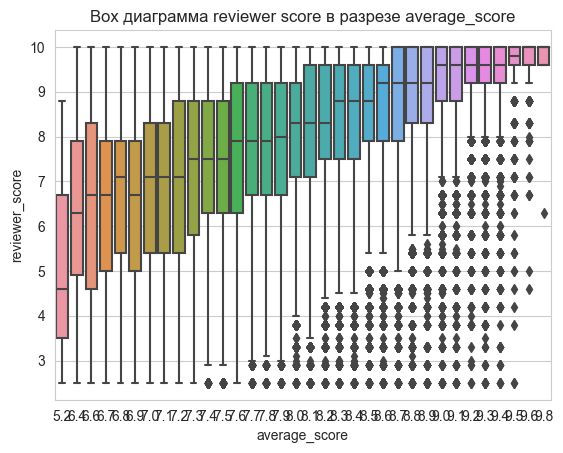

In [71]:
## Смотрю на зависимость средней оценки и оценки пользователя

sns.boxplot(
    df[df['sample']!=0],
    x = 'average_score',
    y = 'reviewer_score',
    orient = 'v',
).set_title('Box диаграмма reviewer score в разрезе average_score')

### Выводы
- Можно заключить, что чем выше оценка средняя, тем выше вероятность получить более высокую оценку

## Обработка комментариев признаков

In [72]:
# Следую рекомендации лектора
# Загружаю словарь и создаю объект для анализа текста
nltk.downloader.download('vader_lexicon') # загружаю словарь
sent_analyzer = SentimentIntensityAnalyzer()

#sent_analyzer.polarity_scores(x) возращает объет, содержащий численную оценку текстовой информации (она может быть сугубо негативной или позитивной
#Создаю 2 новых признака на основе 'compound' оценки

df['negative_compound'] = df.negative_review.apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
df['positive_compound'] = df.positive_review.apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/fandox/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<AxesSubplot: title={'center': 'Гистограмма negative & positive compound'}, xlabel='compound value', ylabel='Percent'>

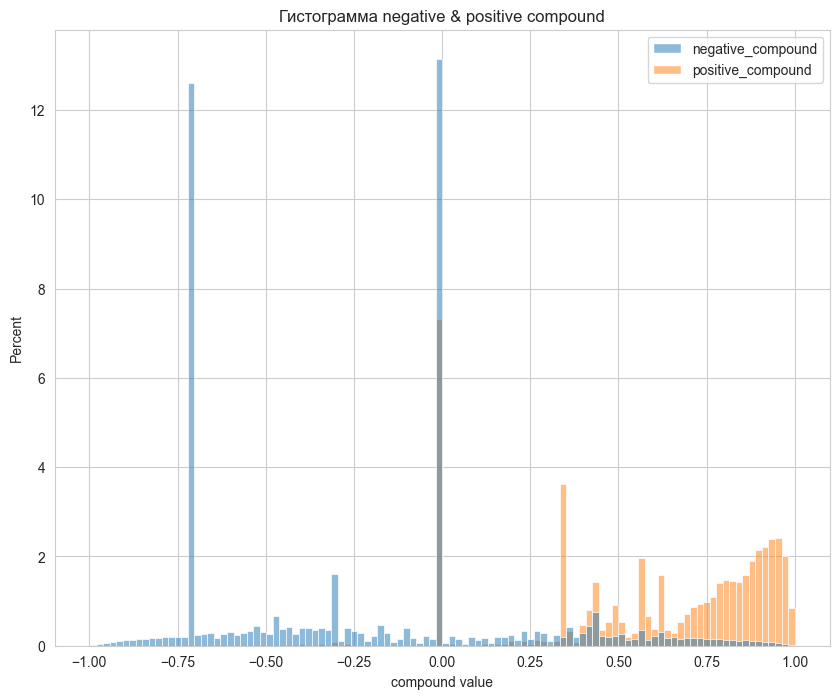

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set(xlabel = 'compound value',title = 'Гистограмма negative & positive compound')

sns.histplot(
    data = df[['negative_compound','positive_compound']],
    ax = ax,
    stat =  'percent'

)

### Вывод
- Люди имею тенденцию заполнять позитивные отзывы чаще чем негативные
- Большинство комментариев пустые
- Позитивные коментрацрии имеют очевидную позитивную окраску
- Негативные комментарии имеют 2 пика


[Text(0.5, 1.0, 'Scatter диаграмма review_total_positive_word_counts в разрезе positive_compound')]

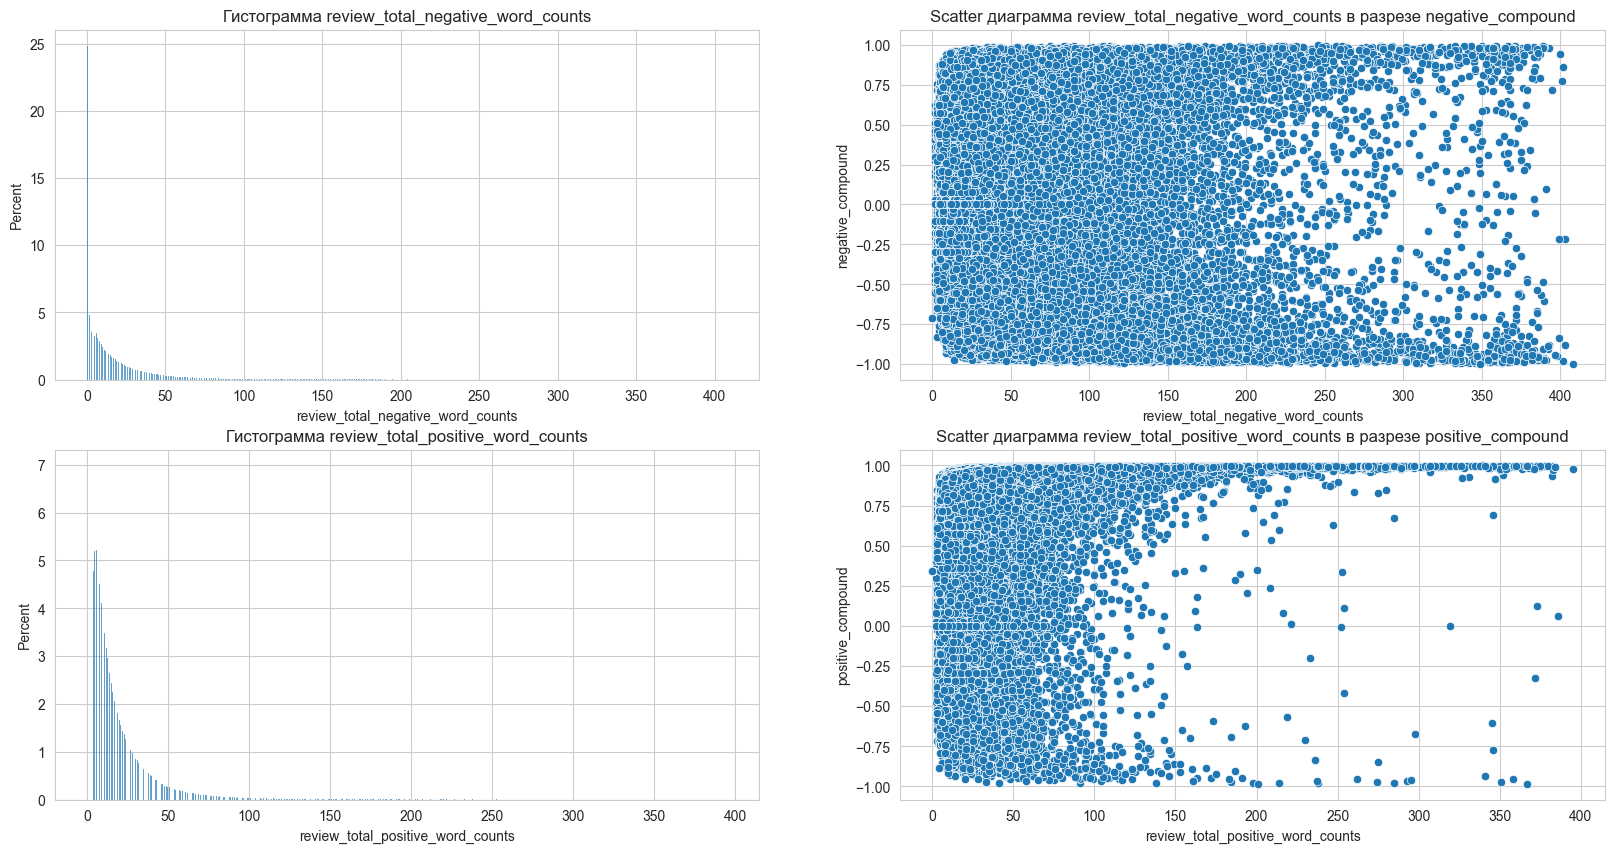

In [74]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(20,10))

sns.histplot(
    x = df['review_total_negative_word_counts'],
    ax = ax1[0],
    stat =  'percent'
)

ax1[0].set(title = 'Гистограмма review_total_negative_word_counts')

sns.histplot(
    data = df['review_total_positive_word_counts'],
    ax = ax2[0],
    stat =  'percent'
)

ax2[0].set(title = 'Гистограмма review_total_positive_word_counts')

sns.scatterplot(
    df,
    x = 'review_total_negative_word_counts',
    y = 'negative_compound',
    ax = ax1[1]
)

ax1[1].set(title = 'Scatter диаграмма review_total_negative_word_counts в разрезе negative_compound')

sns.scatterplot(
    df,
    x = 'review_total_positive_word_counts',
    y = 'positive_compound',
    ax = ax2[1]
)

ax2[1].set(title = 'Scatter диаграмма review_total_positive_word_counts в разрезе positive_compound')




### Вывод
- Оба признака длины комментария имеют распределение близкое к экспоненциальному
- Полярные мнения характеризуются большим количеством символов, использованым для написания комментария


## Выводы
Выделленные признаки можно классифицировать как:
- Описывающие отели
- Описывающие туриста
- Описывающие поездку туриста
- Описывающие фидбек пользователя

# Отбор признаков

In [75]:
# Работаю с копией
df.to_csv('data/dataset.csv')
data = df.copy()

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [77]:
data.head(20)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,inland_tourism,is_from_UK,is_from_US,reviewer_region,trip_type,nights_count,group_type,room_quality,negative_compound,positive_compound
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,1,0,europe,Leisure,2.0,Couple,0,-0.0554,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,europe,Leisure,1.0,Group,0,-0.2960,0.3400
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,0,0,0,europe,Business,1.0,Solo traveler,0,0.0000,0.6908
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,0,0,1,namerica,Leisure,1.0,Couple,0,-0.7096,0.9153
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,0,1,0,europe,Business,2.0,Solo traveler,0,-0.7096,0.7717
5,Coram Street Camden London WC1N 1HT United Kin...,709,8.2,Holiday Inn London Bloomsbury,Ecuador,They don t have free wifi,7,2995,The location is perfect if you don t have a l...,26,...,0,0,0,lamerica,Business,1.0,Solo traveler,0,0.5106,0.6124
6,Empire Way Wembley Brent London HA9 8DS United...,1005,8.3,Holiday Inn London Wembley,United Kingdom,Room generally a bit shabby with some lack of...,35,3469,Location price It did not cost much more to h...,23,...,1,1,0,europe,Leisure,1.0,Couple,1,0.1280,0.5106
7,1 Shortlands Hammersmith and Fulham London W6 ...,704,8.3,Novotel London West,Netherlands,Executive rooms 9th Floor don t have a bath T...,52,2443,Comphy bed upgraded to executive room with ne...,42,...,0,0,0,europe,Business,3.0,Solo traveler,1,0.6124,0.5859
8,35 Rue Caumartin 9th arr 75009 Paris France,211,8.9,Hotel Saint Petersbourg Opera,Ireland,Pity about the two days of rain,8,2412,Its centrality proximity to our destination,7,...,0,0,0,europe,Other,1.0,Group,0,-0.2960,0.0000
9,49 Gloucester Place Marble Arch Westminster Bo...,61,7.4,St George Hotel,Canada,Didn t like it at all construction was in pro...,18,334,Didn t like anything about the stay if i had ...,25,...,0,0,0,namerica,Other,2.0,Couple,0,0.4019,0.3612


### Классификация признаков
__Категориальные номинальные__
- hotel_name
- hotel_address
- hotel_city
- tag
- review_year
- review_month
- review_dayofweek
- hotel_country
- inland_tourism
- is_from_UK
- is_from_US
- reviewer_region
- reviewer_nationality
- negative_review
- positive_review


__Категориальные порядковые__
- lat
- lng
- hotel_distance
- average score
- reviewer_score
- trip_type - спорный момент, может вести к overfitting’y= но в условиях задания игнорирую это
- room_quality - аналогично
- group_type - аналогично


__Числовые признаки__
- days_since_review
- positive compound
- negative_compound
- additional_number_of_scoring
- review_total_positive_word_counts
- review_total_negative_word_counts
- total_number_of_reviews_reviewer_has_given
- review_date

## Удаление малоинформативных признаков
Считаю малоинформативными признакамми:
- где 1 значение представлено более чем в 95% записей
- где количество уникальных значений > 90 % количества записей

In [78]:
# Прохожусь по фрейму, считаю 2 показателя, делаю вывод

for i in data:
    uniqueness = data[i].nunique() / data[i].count()
    frequency = data[i].value_counts(normalize=True).iloc[0] #беру элемент, встречающийся чаще всего
    if uniqueness > 0.9:
        print(f'{i} : {uniqueness}')
    if frequency > 0.95:
        print(f'{i} : {frequency}')

### Вывод
Ни 1 признак таким образом исключить не получилось
Однако, руководствуюясь здавым смыслом исключаю следующие параметры
negative_review - при исключении пустых комментариев, признак малоинформативный
positive_review - при исключении пустых комментариев, признак малоинформативный
tags - обработал, выделил возможную информацию
review_date - обработал, выделил возможную информацию



## Исследование мультиколлинеарности

In [79]:
# Использую коэффициент корреляции Пирсона, т.к речь о категориальных переменных
# Предварительно закодирую порядково все текствоые признаки

encoder = category_encoders.OrdinalEncoder(cols=['hotel_name','hotel_address','reviewer_nationality','hotel_country','hotel_city','reviewer_region','group_type','trip_type'])
data_corr = encoder.fit_transform(data)
data_corr

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,inland_tourism,is_from_UK,is_from_US,reviewer_region,trip_type,nights_count,group_type,room_quality,negative_compound,positive_compound
0,1,904,8.1,1,1,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,1,0,1,1,2.0,1,0,-0.0554,0.9615
1,2,612,8.6,2,2,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,1,1,1.0,2,0,-0.2960,0.3400
2,3,46,8.3,3,3,Pillows,3,351,Nice welcoming and service,5,...,0,0,0,1,2,1.0,3,0,0.0000,0.6908
3,4,241,9.1,4,4,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,0,0,1,2,1,1.0,1,0,-0.7096,0.9153
4,5,834,9.1,5,1,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,0,1,0,1,2,2.0,3,0,-0.7096,0.7717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,724,107,9.0,725,17,No Negative,0,617,Tr s proche du metro Earl s court,10,...,0,0,0,1,1,2.0,2,0,-0.7096,0.0000
515734,925,272,8.4,925,34,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,...,0,0,0,6,1,4.0,1,0,-0.7096,0.7264
515735,272,457,6.8,272,6,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,...,0,0,0,1,2,1.0,3,0,0.0000,0.7845
515736,189,365,8.1,189,20,No Negative,0,1567,Location and very comfy bed,6,...,0,0,0,6,1,2.0,3,1,-0.7096,0.0000


/tmp/ipykernel_288528/377418474.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr.corr('pearson'),


Text(0.5, 1.0, 'Матрица корреляции data')

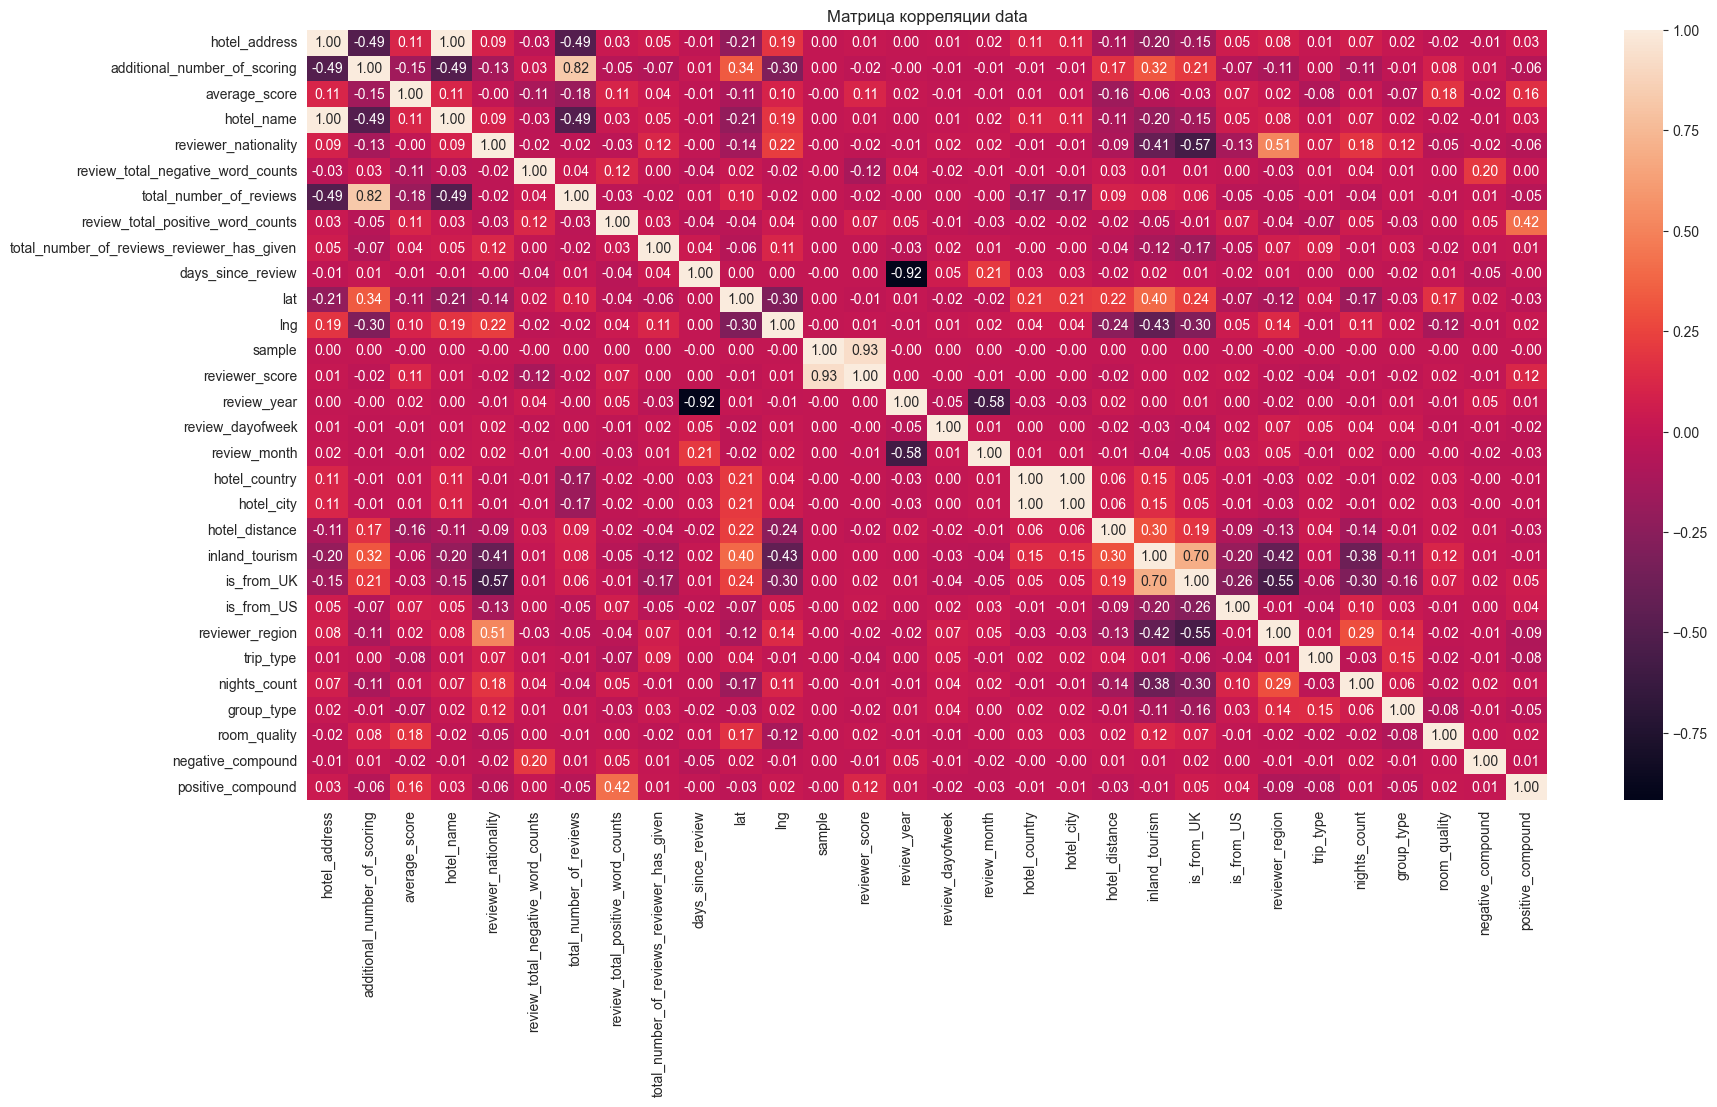

In [80]:
plt.subplots(figsize=(20, 10))

sns.heatmap(
    data_corr.corr('pearson'),
    annot= True,
    fmt = '.2f'
).set_title('Матрица корреляции data')

### Вывод
Выбрал следующие признаки для удаления
- hotel_address
- additional_number_of_scoring
- lat, lng (пара этих значений, по факту, это адрес)
- reviewer_year
- hotel_city

Оставляю признак
- is_form_UK

Из того, что удивило, не определена мультиколлинеарность между hotel_distance и hotel_address

In [81]:
# Выполненяю удаление выбранных признаков
data = data.drop([
    'hotel_address',
    'additional_number_of_scoring',
    'lat',
    'lng',
    'review_year',
    'tags',
    'negative_review',
    'positive_review',
    'hotel_city'
],axis = 1)

In [82]:
data.head()

,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,...,inland_tourism,is_from_UK,is_from_US,reviewer_region,trip_type,nights_count,group_type,room_quality,negative_compound,positive_compound
0,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,13,0,0.0,...,0,1,0,europe,Leisure,2.0,Couple,0,-0.0554,0.9615
1,8.6,Urban Lodge Hotel,Belgium,10,5018,0,7,234,0,0.0,...,0,0,0,europe,Leisure,1.0,Group,0,-0.2960,0.3400
2,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,3,351,5,15,616,0,0.0,...,0,0,0,europe,Business,1.0,Solo traveler,0,0.0000,0.6908
3,9.1,Hotel Principe Di Savoia,United States of America,0,1543,27,9,656,0,0.0,...,0,0,1,namerica,Leisure,1.0,Couple,0,-0.7096,0.9153
4,9.1,Hotel Esther a,United Kingdom,0,4687,7,2,444,0,0.0,...,0,1,0,europe,Business,2.0,Solo traveler,0,-0.7096,0.7717


## Кодирование признаков

In [83]:
# Кодирую создаю словари для последующего порядкового кодирования
# Подобное действие может считаться overfitting’ом но дает лучшие результаты на данном задании

group_types = {
    'Couple': 5,
    'Group': 4,
    'Solo traveler': 1,
    'Family with older children': 3,
    'Family with young children': 2,
    'Travelers with friends': 6
}

trips_type = {
    'Leisure': 3,
    'Business': 1,
    'Other': 2
}

encoder_list = [{
    'col':'group_type',
    'mapping':group_types
},{
    'col':'trip_type',
    'mapping':trips_type
}]


In [84]:
# Порядковое кодирование для порядковых признаков
encoder_ordinal = category_encoders.OrdinalEncoder(cols = ['trip_type','group_type'], mapping = encoder_list)
data = encoder_ordinal.fit_transform(data)

In [85]:
encoder_ordinal = category_encoders.OrdinalEncoder(cols = ['average_score'])
data = encoder_ordinal.fit_transform(data.sort_values(by='average_score'))

In [86]:
encoder_ordinal = category_encoders.OrdinalEncoder(cols=['hotel_distance'])
data = encoder_ordinal.fit_transform(data.sort_values(by='hotel_distance'))

In [87]:
# Бинарное кодирование для номинальных признаков с большой вариативностью
encoder_binary = category_encoders.BinaryEncoder(cols = ['reviewer_nationality'])
data = encoder_binary.fit_transform(data)

In [88]:
# Порядковое кодирование для номинальных призков
encoder_onehot = category_encoders.OneHotEncoder(cols = ['reviewer_region','hotel_country','review_month','review_dayofweek'])
data = encoder_onehot.fit_transform(data)


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 56663 to 340431
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  int64  
 1   hotel_name                                  515738 non-null  object 
 2   reviewer_nationality_0                      515738 non-null  int64  
 3   reviewer_nationality_1                      515738 non-null  int64  
 4   reviewer_nationality_2                      515738 non-null  int64  
 5   reviewer_nationality_3                      515738 non-null  int64  
 6   reviewer_nationality_4                      515738 non-null  int64  
 7   reviewer_nationality_5                      515738 non-null  int64  
 8   reviewer_nationality_6                      515738 non-null  int64  
 9   reviewer_nationality_7                      515738 non-null  int64

In [90]:
# Дополнительно удаляю признаки, которые имеют малое влияние
data.drop(['is_from_US','is_from_UK','hotel_name'],axis = 1, inplace = True)

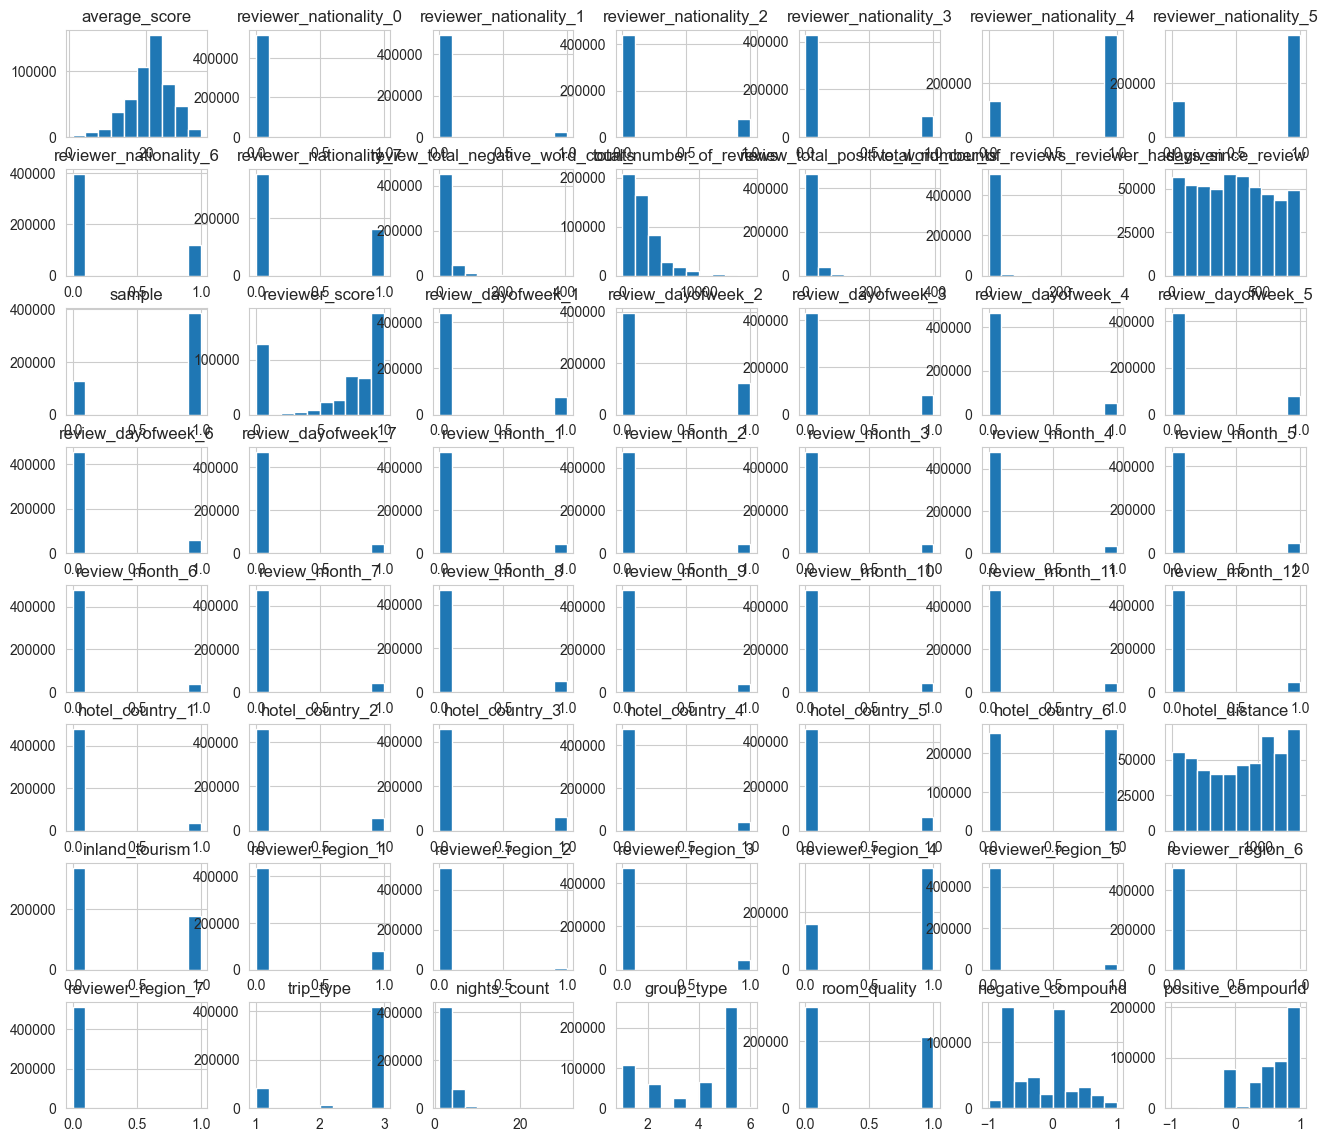

In [109]:
# checking numeric data
data.hist(figsize=(16,14))
experiment.log_figure(figure=plt)

In [92]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [93]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [94]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [95]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 55), (386803, 55), (386803, 54), (309442, 54), (77361, 54))

In [96]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [97]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


In [98]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Использую 2 метрики: MAE, MAPE
# Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.

mae = metrics.mean_absolute_error(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE:{mae:.4f}')
print(f'MAPE:{mape:.8f}')

MAE:0.8724
MAPE:0.12417427


In [99]:
experiment.log_metric('MAE',mae)
experiment.log_metric('MAPE',mape)

{'web': 'https://www.comet.com/api/image/download?imageId=bc2ccbe296034a13b44f489152e19741&experimentKey=94a0731128034016b0d3876b7edd2227',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=bc2ccbe296034a13b44f489152e19741&experimentKey=94a0731128034016b0d3876b7edd2227',
 'imageId': 'bc2ccbe296034a13b44f489152e19741'}

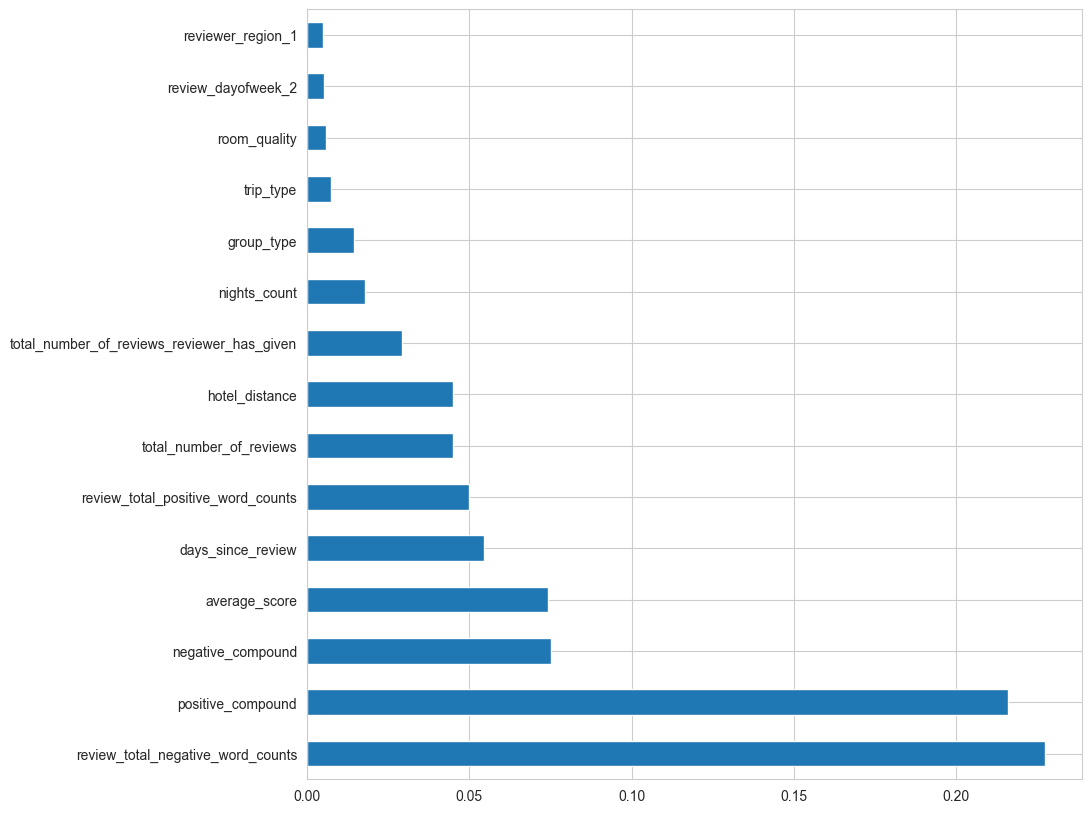

In [100]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

experiment.log_figure(plt)

### Выводы
- Нормализация и стандартизация не имеют эффекта на модель
- Удаление слабых признаков не имеют эффекта на модель
- Как и ожидалось, самые сильные признаки, это признаки, относящиеся к комметарию пользователя

In [101]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 56663 to 3374
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               128935 non-null  int64  
 1   reviewer_nationality_0                      128935 non-null  int64  
 2   reviewer_nationality_1                      128935 non-null  int64  
 3   reviewer_nationality_2                      128935 non-null  int64  
 4   reviewer_nationality_3                      128935 non-null  int64  
 5   reviewer_nationality_4                      128935 non-null  int64  
 6   reviewer_nationality_5                      128935 non-null  int64  
 7   reviewer_nationality_6                      128935 non-null  int64  
 8   reviewer_nationality_7                      128935 non-null  int64  
 9   review_total_negative_word_counts           128935 non-null  int64  

In [102]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [103]:
sample_submission

,reviewer_score,id
0,9.716,488440
1,9.739,274649
2,9.548,374688
3,9.401,404352
4,9.683,451596
...,...,...
128930,9.303,495812
128931,7.446,315577
128932,5.064,511968
128933,6.839,303386


In [104]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished


In [105]:
predict_submission

array([9.716, 9.739, 9.548, ..., 5.064, 6.839, 7.563])

In [106]:
list(sample_submission)

['reviewer_score', 'id']

In [107]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,9.716,488440
1,9.739,274649
2,9.548,374688
3,9.401,404352
4,9.683,451596
5,8.658,302161
6,9.556,317079
7,9.322,13963
8,9.395,159785
9,9.788,195089


In [108]:
# Завершаю эксперимент
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/fandox/ds-project3/94a0731128034016b0d3876b7edd2227
COMET INFO:   Metrics:
COMET INFO:     MAE  : 0.8724013133232502
COMET INFO:     MAPE : 0.12417426907438485
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 2
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can st

# Выводы
В рамках этой работы было выполнено:
- Удаление признаков
- Создание новых признаков
- Отбор признаков
- Обучение подели

Модель оказалась устойчива к
- Вариациям в распределении признаков
- Попыткам нормализации
- Присутствию малоинформативных признаков